In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import geopandas as gpd
import gdal
import os
import rasterio as rio
from rasterio.plot import show
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Importing data

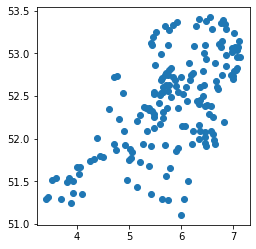

In [3]:
points_top_Soil = gpd.read_file('LUCAS_Topsoil_2015_20200323-shapefile/LUCAS_Topsoil_2015_20200323.shp')
NLD_boundaries = gpd.read_file('NLD_shapefile/gadm36_NLD_0.shp')

# Select by location based on the boundaries of teh Netherlands
# Firstly, I checked if the two files have the same epsg
NLD_boundaries.crs == NLD_boundaries.crs
polygon_NLD = NLD_boundaries.geometry[0]
points_NLD = points_top_Soil[points_top_Soil.within(polygon_NLD)]
points_NLD.plot()
#os.makedirs("top_soil_NLD")
points_NLD.to_file('top_soil_NLD/top_soil_NLD.shp')

In [7]:
interpolated_clay = gdal.Grid('top_soil_NLD/interpolation_clay_sand_silt/interpolated_clay.tiff', 'top_soil_NLD/top_soil_NLD.shp', zfield='Clay', algorithm = 'linear:radius=0')
interpolated_sand = gdal.Grid('top_soil_NLD/interpolation_clay_sand_silt/interpolated_sand.tiff', 'top_soil_NLD/top_soil_NLD.shp', zfield='Sand', algorithm = 'linear:radius=0')
interpolated_silt = gdal.Grid('top_soil_NLD/interpolation_clay_sand_silt/interpolated_silt.tiff', 'top_soil_NLD/top_soil_NLD.shp', zfield='Silt', algorithm = 'linear:radius=0')

In [8]:
cwd = os.getcwd()
data_path = os.path.join(cwd, 'top_soil_NLD\interpolation_clay_sand_silt')

In [9]:
images = []
arrays_table= []

for i in os.listdir(data_path):
    path_file= os.path.join(data_path, i)
    file = rio.open(path_file)
    mask_file = file.read_masks(1)
    data_mask = np.ma.masked_array(file.read(1), mask_file==0)
    images.append(file)
    arrays_table.append(data_mask)

# Ploting soil content percentages

Text(-0.35, -0.1, 'Soil content')

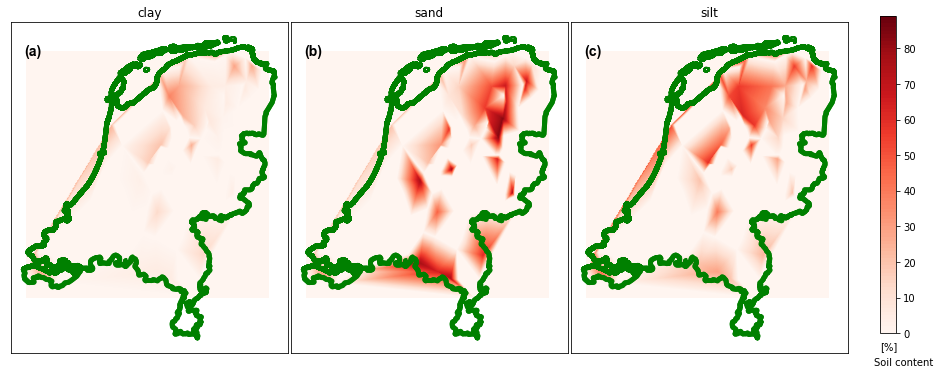

In [10]:
fig, axs = plt.subplots(1,3,figsize=(15,8))
labels_font = {'fontname':'Arial', 'size':'14', 'weight':'bold'}

fig.subplots_adjust(hspace = .15, wspace=.011)
soil_types = ['clay', 'sand', 'silt']
letters = ['a','b', 'c']
axs = axs.ravel()

for i in range(3):
    rio.plot.show(images[i], ax=axs[i],  cmap='Reds', vmin=0, vmax=90)
    NLD_boundaries.plot(ax=axs[i], facecolor='none', edgecolor='green', linewidth=5)
    axs[i].invert_yaxis()
    NLD_boundaries.plot(ax=axs[i], facecolor='none', edgecolor='green', linewidth=5)
    axs[i].set_yticklabels([])
    axs[i].set_xticklabels([])
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].set_title(soil_types[i])
    axs[i].text(0.05, 0.9, '('+str(letters[i])+')', **labels_font, transform=axs[i].transAxes)

# Plotling the colorbar
cbar_ax = fig.add_axes([0.93, 0.25, 0.015, 0.55])
sm = plt.cm.ScalarMappable(cmap='Reds')
colorbar = fig.colorbar(sm, cax=cbar_ax, ticks=range(0,1), boundaries=np.arange(0, 90), fraction=0.049)
colorbar.set_ticks(np.arange(0, 100, 10))
plt.text(0, -0.05, '[%]', transform=cbar_ax.transAxes)
plt.text(-0.35, -0.10, 'Soil content', transform=cbar_ax.transAxes)

# DEM

Digital Elevation Model (DEM) was derived from https://earthexplorer.usgs.gov/. More specifically, the Global Multi-resolution Terrain Elevation Data 2010 (GMTED2010) was used. The spatial resolution used was 30 arc second. Data is available at 7.5 arc second but coarse data was selected due to storage limitations. More information about the dataset can be found here https://www.usgs.gov/centers/eros/science/usgs-eros-archive-digital-elevation-global-multi-resolution-terrain-elevation?qt-science_center_objects=0#qt-science_center_objects. In addition, clipping between NLD shapefile and DEM was conducted in QGIS. 


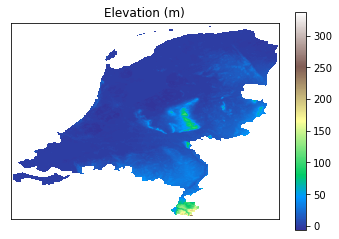

In [48]:
file = rio.open('DEM_clip_NLD/DEM_clip_NLD.tif')
mask_file = file.read_masks(1)
data_mask = np.ma.masked_array(file.read(1), mask_file==0)
plt.imshow(data_mask, cmap='terrain')
plt.colorbar()
plt.title('Elevation (m)');
plt.yticks([])
plt.xticks([]);

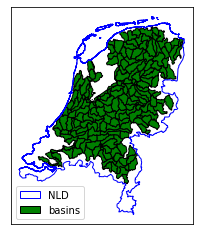

In [34]:
basins_NLD = gpd.read_file('Basins_NLD/basins_NLD_within.shp')
import matplotlib.patches as mpatches
LegendElement = [
                 mpatches.Patch(facecolor='None', edgecolor='blue', label='NLD'),
                 mpatches.Patch(facecolor='green', edgecolor='black', label='basins')]

fig, ax  = plt.subplots()
basins_NLD.plot(facecolor='green', edgecolor='black', ax=ax)
NLD_boundaries.plot(facecolor='None', edgecolor='blue', ax=ax)
ax.legend(handles = LegendElement, loc='lower left')
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_xticks([]);

# DEM zonal statistics

In [59]:
from rasterstats import zonal_stats
DEM_mean = zonal_stats("Basins_NLD/basins_NLD_within.shp", 'DEM_clip_NLD/DEM_clip_NLD.tif',
            stats="mean")
DEM_mean_list = [DEM_mean[i]['mean'] for i in range(len(DEM_mean))]
DEM_mean_df = pd.DataFrame(DEM_mean_list, columns=['DEM_mean'])